In [2]:
---
title: Solution Deployment & Communication - Lab 2
author: Andreas Weigl-Pollack
description: Covid Dashboard
show-code: False
show-prompt: False
params:
    inYears:
        label: Date
        input: range
        value: [2021, 2022]
        min: 2020
        max: 2023
    header:
        output: markdown
        value: |
            Show elements
    inShowConfirmed:
        label: Confirmed
        input: checkbox
        value: True
    inShowDeaths:
        label: Deaths
        input: checkbox
        value: True
    inShowRecovered:
        label: Recovered
        input: checkbox
        value: True
    inShowTests:
        label: Tests
        input: checkbox
        value: True
    inShowVaccines:
        label: Vaccines
        input: checkbox
        value: True
    inShowHosp:
        label: Hosp
        input: checkbox
        value: True
    inShowIcu:
        label: ICU
        input: checkbox
        value: True
    inCountry:
        label: Country
        input: select
        value: ["AUT", "USA"]
        choices: ["AUT", "DEU", "ITA", "USA"]
        multi: True
    inSmoothen:
        label: Smoothen graph
        input: checkbox
        value: True
---

SyntaxError: invalid syntax (Temp/ipykernel_8920/1973083290.py, line 1)

In [1]:
# default values for execution without Mercury
inYears= [2021, 2022]
inShowConfirmed= True
inShowDeaths= True
inShowRecovered= True
inShowTests= True
inShowVaccines= True
inShowHosp= True
inShowIcu= True
inCountry= ["AUT", "USA"]
inSmoothen= True

In [ ]:
# # Solution Deployment & Communication
# Lab 2

# Andreas Weigl-Pollack

In [ ]:
# Versuchen Sie Ihre Überlegungen zu Dashboards aus der letzten Übung (Virtualisierung von Covid-19 Daten) in die Praxis umzusetzen. Das Endergebnis
# muss dabei nicht exakt mit Ihren Skizzen von Übung 1 übereinstimmen. Verwenden Sie dazu Streamlit oder Flask und binden Sie eine FastAPI ein.

# Kriterien dabei sind:
# * Es gibt mindestens 2 verschiedene interaktive Elemente, um eine Auswahl zu treffen (z.B. Dropdown-Liste zur Auswahl einer Jahreszahl sowie Radio-Buttons zur Auswahl des Kontinents)
# * Es gibt mindestens 2 verschiedene Grafiken, welche Ergebnisse visualisieren (überlegen Sie nochmals, welche Grafikform Ihre Daten am besten darstellt)
# * Das gesamte Dashboard ist interaktiv (z.B. Auswahl aus Dropdown-Liste verändert die Grafik, Auswahl eines Radio-Buttons verändert ebefalls andere Teile)
# * Fügen Sie zumindest einfache Formatierungen mit Hilfe von CSS-Formaten ein
# * Erstellen Sie weiters eine FastAPI. Die Funktionalität kann einfach sein, z.B. übergeben Sie einen Zahlenwert als Grad Celsius und Sie bekommen Grad Fahrenheit zurück.
# * Greifen Sie aus dem Dashboard auf die erstellte FastAPI zu. Sehen Sie irgendeine Möglichkeit vor Daten zu übergeben (z.B. über ein Texteingabefeld oder indem sonst irgendwie die Daten bestimmt werden) und zeigen Sie das Resultat an.

# Fassen Sie Ihre Ergebnisse inklusive Dokumentation in einem Jupyter Notebook (.ipynb) oder diesmal auch als Python-File (.py) zusammen und geben Sie dieses in Moodle ab

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Auto reloads notebook when changes are made
%reload_ext autoreload
%autoreload 2

In [11]:
#!pip install covid19dh

# COVID-19 Data Hub
# Funded by the Institute for Data Valorization IVADO, Canada.
# <https://covid19datahub.io/articles/python.html>

from covid19dh import covid19
from datetime import datetime

# filter data to this year
df_covid, src = covid19(
    country= inCountry,
    start = datetime(inYears[0],1,1),
    end= datetime(inYears[1],12,31),
    verbose = False
)

# convert to time series and use country as index, since otherwise data from different countries are mixed at later .diff()
df_covid0= df_covid.rename(columns = {'iso_alpha_3':'country'}).set_index(["country", "date"]).sort_index()

# select only a few rows
df_covid1= df_covid0[["confirmed", "deaths", "recovered", "tests", "vaccines", "hosp", "icu", "population"]].copy()

# since ["confirmed", "deaths", "recovered", "tests", "vaccines"] are cumulative, calculate and use the daily diff
df_covid1[["confirmed", "deaths", "recovered", "tests", "vaccines"]]= df_covid1[["confirmed", "deaths", "recovered", "tests", "vaccines"]].diff()
#df_covid1

In [4]:
# evaluate selected fields
selectedFields=[]
if inShowConfirmed:
    selectedFields.append("confirmed")
if inShowDeaths:
    selectedFields.append("deaths")
if inShowRecovered:
    selectedFields.append("recovered")
if inShowTests:
    selectedFields.append("tests")
if inShowVaccines:
    selectedFields.append("vaccines")
if inShowHosp:
    selectedFields.append("hosp")
if inShowIcu:
    selectedFields.append("icu")
#selectedFields

In [5]:
# output the selected fields as tabular data
df_covid2= df_covid1.reset_index().set_index("date").groupby("country").resample("Y").median()[selectedFields+["population"]] # yearly, use median
df_covid2

confirmed  deaths  recovered      tests   vaccines  \
country date                                                             
AUT     2021-12-31     1696.5    23.0     1724.0   325511.0    32650.0   
        2022-12-31     8288.0    10.0     8116.0   115793.0     6241.5   
USA     2021-12-31    70499.5   956.5        NaN  1296443.0  1138384.0   
        2022-12-31    73487.5   509.5        NaN   985731.0   337065.0   

                       hosp      icu   population  
country date                                       
AUT     2021-12-31    822.5    261.5    8840521.0  
        2022-12-31   1183.5     86.0    8840521.0  
USA     2021-12-31  46380.0  12455.0  326687501.0  
        2022-12-31  25712.5   3229.0  326687501.0

In [6]:
# generic routine to visualize covid19dh dataframe
def VisualizeCovidData(df, elements, countries, title):
    fig, axs = plt.subplots(len(elements), len(countries), figsize=(20,20))
    fig.suptitle(title)

    for i, element in enumerate(elements):
        # separate for one and multiple countries, otherwise indexing of axs fails
        if len(countries)>1:
            for j, country in enumerate(countries):
                axs[i,j].set_title(element+"@"+country)
                axs[i,j].plot(df[df.country==country][element])
        else:
            axs[i].set_title(element+"@"+countries[0])
            axs[i].plot(df[element])

    plt.gcf().autofmt_xdate()
    plt.show()

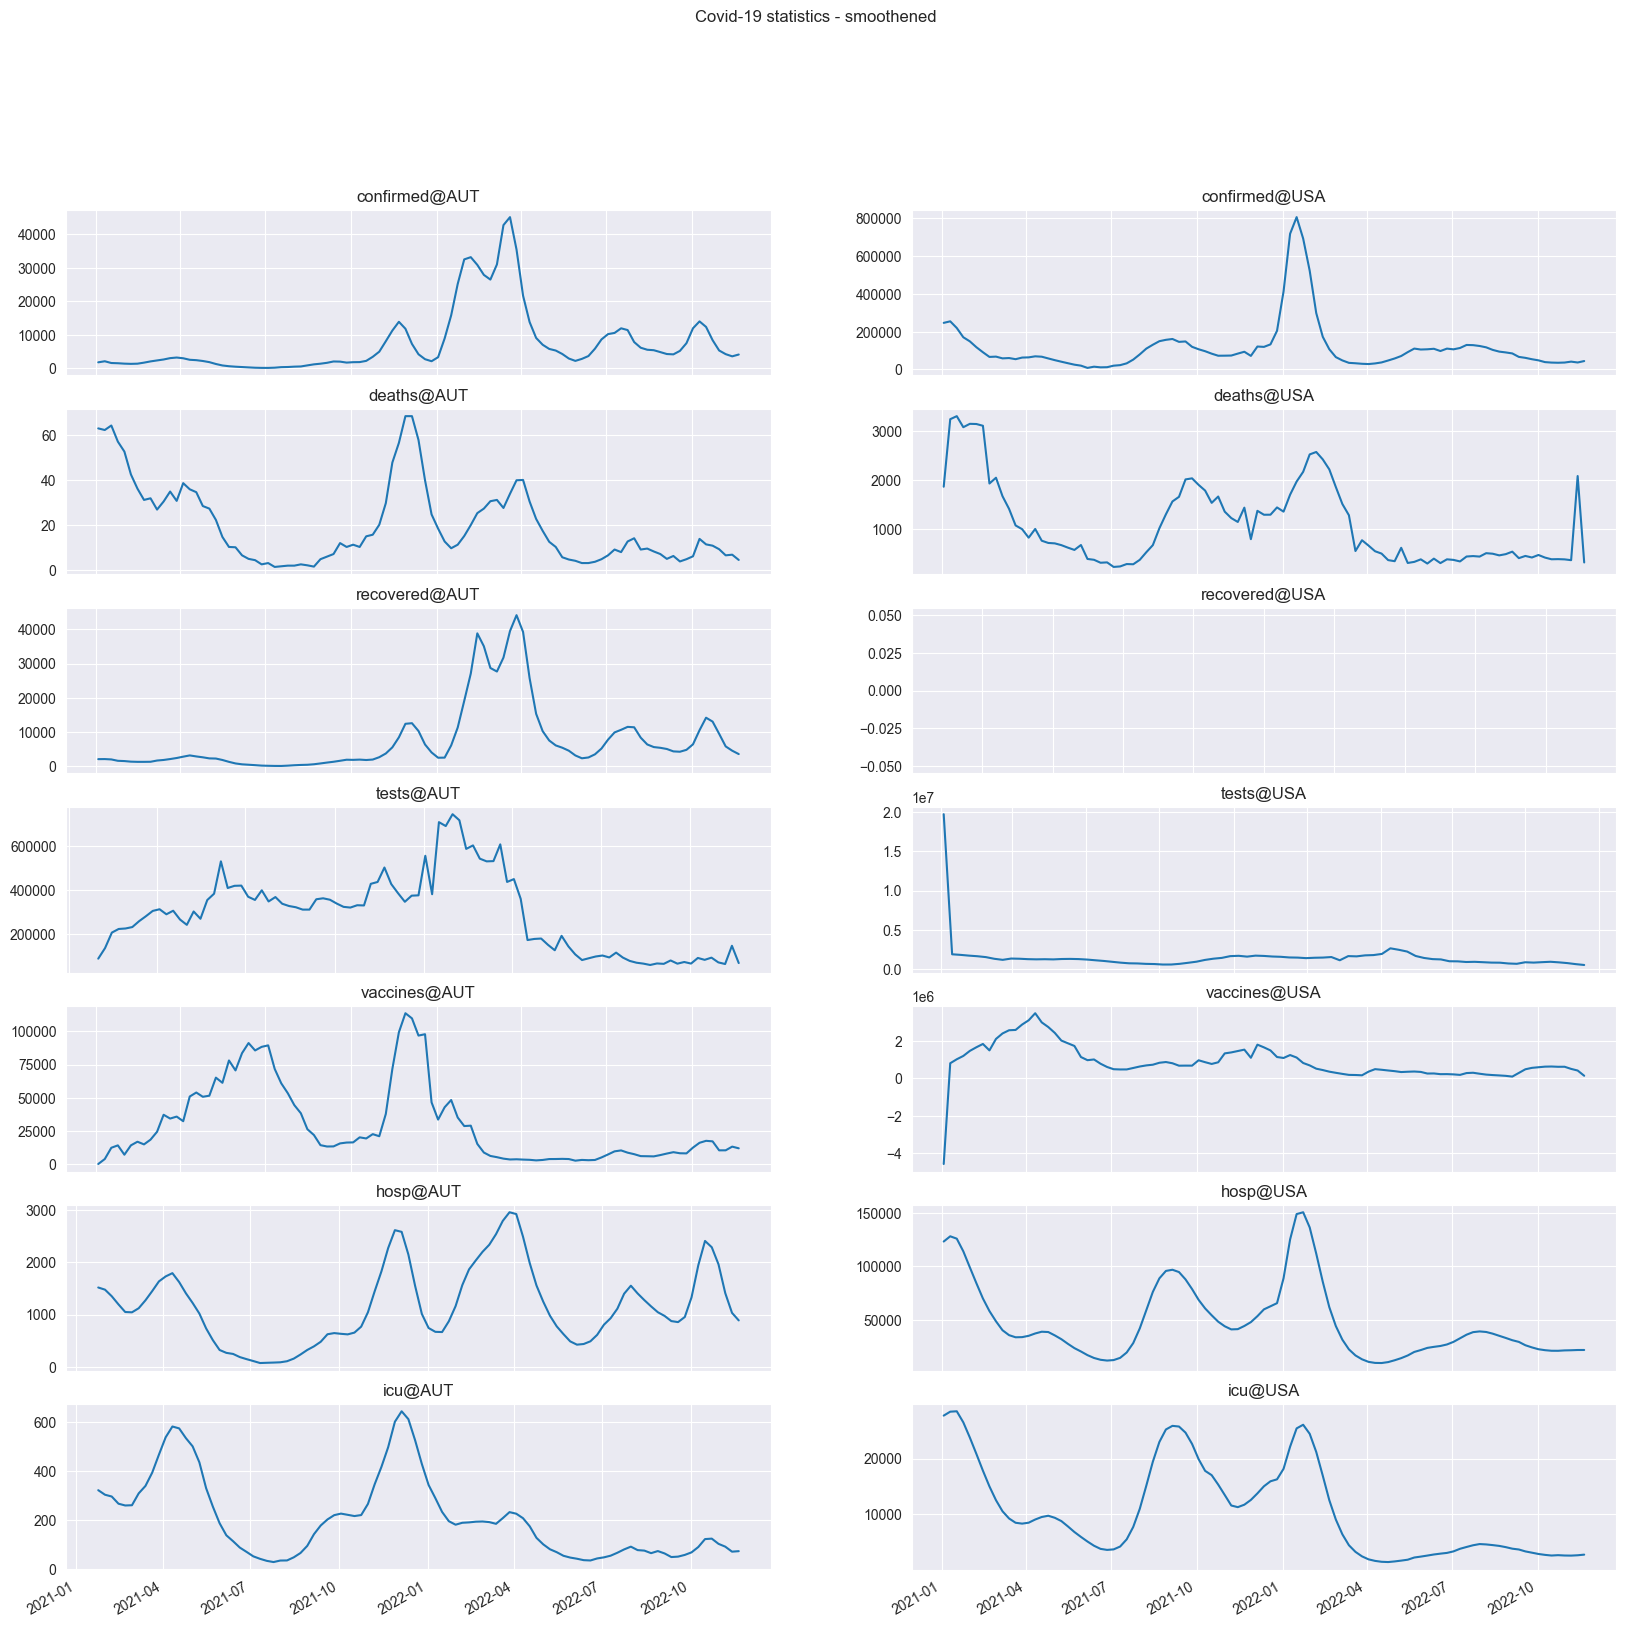

In [7]:
# visualize using the original or smoothened data
if inSmoothen:
    # visualize smoothened data
    df_covid3= df_covid1.reset_index().set_index("date").groupby("country").resample("W").mean()[selectedFields].reset_index().set_index("date")
    df_covid3
    VisualizeCovidData(df_covid3, selectedFields, inCountry, "Covid-19 statistics - smoothened")
else:
    VisualizeCovidData(df_covid1, selectedFields, inCountry, "Covid-19 statistics")